In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from numpy import split
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras import callbacks
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [3]:
# Load the new file
dataset = pd.read_csv("Final_data.csv")

The data starts from 01/03/2013 and ends on 28/02/2017.We will use the first three years of data for training predictive models and the final year for evaluating models. Hence, number of training days is 01/03/2013 - 29/02/2016, equals to 1096 days, i.e. 26304 hr. Number of test days is 01/03/2016 - 28/02/2017, 365 days, equals to 8760 hr.

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

# Split and scale the dataset into train/test sets

def Split_dataset(data):
    # Split into train_data (1096 days X 24 hr) and val_data (219 days X 24 hr), test_data (146 days X 24 hr )
    train_data, val_data, test_data = data[0:-8760], data[-8760:-3504], data[-3504:]
    
    # scale the data using min max scaling on training data
    train = scaler.fit_transform(train_data)
    val = scaler.transform(val_data)
    test = scaler.transform(test_data)
    
    # Restructure into windows of 24hrs
    train = np.array(np.split(train, len(train) / 24))
    val = np.array(np.split(val, len(val) / 24))
    test = np.array(np.split(test, len(test) / 24))

    return train, val, test


In [5]:
# Split into train and test
train, val, test = Split_dataset(dataset.values)

In [6]:
print(train.shape)
print(val.shape)
print(test.shape)

(1096, 24, 22)
(219, 24, 22)
(146, 24, 22)


We want to prepare the training data such that we iterate over the time steps and divide the data into overlapping windows; each iteration moves along 24 time steps (24hrs) and predicts the subsequent step 1hr.

*   Input Output
*   [h01, h02, h03, h04, . . . . , h21, h22, h23, h24], [h25]
*   [h02, h03, h04, h05, . . . . ,h22, h23, h24, h25], [h26]







In [7]:
# Convert series to supervised inputs and outputs

def to_supervised(data, n_input=24, n_out=1):
    # flatten data
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    X, y = list(), list()
    in_start = 0

    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])

        # move along one time step
        in_start += 1

    return np.array(X), np.array(y)



In [8]:
# fit a model
def model_fit(train, val, config):

    n_input, n_nodes, n_drop, n_epochs, n_batch = config

    # Prepare training data
    train_X, train_y = to_supervised(train, n_input=24)
    val_X, val_y = to_supervised(val, n_input =24)

    # Build the model
    tf.random.set_seed(7)
    np.random.seed(7)
    n_input, n_features = train_X.shape[1], train_X.shape[2]
    n_steps = train_X.shape[1]*train_X.shape[2]

    # Define the model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim = n_steps))
    model.add(Dropout(n_drop))
    model.add(Dense(1))

    # Compile the model
    model.compile(loss = 'mse' , optimizer= Adam(learning_rate = 0.001))

    es_callback = callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4,
                  patience=50, restore_best_weights=True)

    # define inputs
    train_X = train_X.reshape((train_X.shape[0], n_steps))
    val_X = val_X.reshape((val_X.shape[0], n_steps))

    # fit model
    model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1, validation_data = (val_X,val_y),callbacks=[es_callback])

    return model

In [9]:
def model_predict(test, config):
    # unpack config
    n_input, _, _, _, n_batch = config

    # convert config to a key
    key = str(config)

    model = model_fit(train, val, config)

    # shape input for model
    test_X, test_y = to_supervised(test, n_input =24)
    input_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))

    # make forecast
    yhat = model.predict(input_X)

    # actual observation
    test_y = test_y.reshape(-1,1)

    # invert scaling for actual
    inv_test_y = concatenate((test_y, input_X[:, -21:]), axis=1)
    inv_test_y = scaler.inverse_transform(inv_test_y)
    inv_test_y= inv_test_y[:, 0]

    # invert scaling for predictions
    inv_yhat = concatenate((yhat, input_X[:, -21:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # estimate prediction error
    rmse = sqrt(mean_squared_error(inv_test_y,inv_yhat))
    mae = mean_absolute_error(inv_test_y, inv_yhat)
    R2=r2_score(inv_test_y, inv_yhat)
    
    print('> Model[%s] %.3f %.3f %.3f' % (key, rmse, mae, R2))

    return (key, rmse, mae, R2)

In [10]:
# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [24]
    n_nodes = [100, 200]
    n_drop = [0.1, 0.2]
    n_epochs = [200]
    n_batch = [12, 24, 48]

    # create configs
    configs = list()
    for i in n_input:
      for j in n_nodes:
        for k in n_drop:
          for l in n_epochs:
            for m in n_batch:
              cfg = [i, j, k, l, m]
              configs.append(cfg)
      print('Total configs: %d' % len(configs))
    return configs

In [11]:
cfg_list = model_configs()
cfg_list

Total configs: 12


[[24, 100, 0.1, 200, 12],
 [24, 100, 0.1, 200, 24],
 [24, 100, 0.1, 200, 48],
 [24, 100, 0.2, 200, 12],
 [24, 100, 0.2, 200, 24],
 [24, 100, 0.2, 200, 48],
 [24, 200, 0.1, 200, 12],
 [24, 200, 0.1, 200, 24],
 [24, 200, 0.1, 200, 48],
 [24, 200, 0.2, 200, 12],
 [24, 200, 0.2, 200, 24],
 [24, 200, 0.2, 200, 48]]

In [12]:
# grid search configs
def grid_search(cfg_list):

    # fit and evaluate the model n times
    scores = [model_predict(test, config) for config in cfg_list]

    # sort configs by rmse, asc
    scores.sort(key=lambda tup: tup[1])

    return scores

In [15]:
# grid search
scores = grid_search(cfg_list)
print('done')

# list configs in ascending order of rmse
for config, rmse, mae, R2 in scores:
    print('> Model[%s] %.3f %.3f %.3f' % (config, rmse, mae, R2))


Epoch 1/200
2190/2190 [==============================] - 7s 3ms/step - loss: 0.0031 - val_loss: 5.4521e-04
Epoch 2/200
2190/2190 [==============================] - 6s 3ms/step - loss: 9.0168e-04 - val_loss: 7.9379e-04
Epoch 3/200
2190/2190 [==============================] - 6s 3ms/step - loss: 8.3197e-04 - val_loss: 3.9890e-04
Epoch 4/200
2190/2190 [==============================] - 6s 3ms/step - loss: 7.7420e-04 - val_loss: 5.0653e-04
Epoch 5/200
2190/2190 [==============================] - 6s 3ms/step - loss: 7.3077e-04 - val_loss: 5.7666e-04
Epoch 6/200
2190/2190 [==============================] - 6s 3ms/step - loss: 7.5588e-04 - val_loss: 4.6626e-04
Epoch 7/200
2190/2190 [==============================] - 6s 3ms/step - loss: 7.3564e-04 - val_loss: 3.3402e-04
Epoch 8/200
2190/2190 [==============================] - 6s 3ms/step - loss: 7.1546e-04 - val_loss: 4.8462e-04
Epoch 9/200
2190/2190 [==============================] - 6s 3ms/step - loss: 7.1419e-04 - val_loss: 5.6578e-04
Epoch

Epoch 13/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.1476e-04 - val_loss: 4.0663e-04
Epoch 14/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.1203e-04 - val_loss: 3.5483e-04
Epoch 15/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.2243e-04 - val_loss: 0.0011
Epoch 16/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.2055e-04 - val_loss: 3.8746e-04
Epoch 17/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.1440e-04 - val_loss: 3.3380e-04
Epoch 18/200
1095/1095 [==============================] - 3s 2ms/step - loss: 5.9042e-04 - val_loss: 2.9247e-04
Epoch 19/200
1095/1095 [==============================] - 3s 2ms/step - loss: 5.9595e-04 - val_loss: 3.1203e-04
Epoch 20/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.0459e-04 - val_loss: 3.2709e-04
Epoch 21/200
1095/1095 [==============================] - 3s 2ms/step - loss: 5.8706e-04 - val_loss: 2.9572e

548/548 [==============================] - 2s 3ms/step - loss: 5.8638e-04 - val_loss: 3.1600e-04
Epoch 19/200
548/548 [==============================] - 2s 3ms/step - loss: 5.6889e-04 - val_loss: 3.4841e-04
Epoch 20/200
548/548 [==============================] - 2s 3ms/step - loss: 5.9365e-04 - val_loss: 3.1423e-04
Epoch 21/200
548/548 [==============================] - 2s 3ms/step - loss: 5.8341e-04 - val_loss: 3.3541e-04
Epoch 22/200
548/548 [==============================] - 2s 3ms/step - loss: 5.9361e-04 - val_loss: 2.8814e-04
Epoch 23/200
548/548 [==============================] - 2s 3ms/step - loss: 5.6736e-04 - val_loss: 2.6760e-04
Epoch 24/200
548/548 [==============================] - 2s 3ms/step - loss: 5.8615e-04 - val_loss: 2.7575e-04
Epoch 25/200
548/548 [==============================] - 2s 3ms/step - loss: 5.7096e-04 - val_loss: 4.3401e-04
Epoch 26/200
548/548 [==============================] - 2s 3ms/step - loss: 5.6267e-04 - val_loss: 2.6594e-04
Epoch 27/200
548/548 [=

Epoch 30/200
2190/2190 [==============================] - 4s 2ms/step - loss: 8.2138e-04 - val_loss: 3.2215e-04
Epoch 31/200
2190/2190 [==============================] - 4s 2ms/step - loss: 8.3235e-04 - val_loss: 2.8179e-04
Epoch 32/200
2190/2190 [==============================] - 4s 2ms/step - loss: 7.7926e-04 - val_loss: 2.7672e-04
Epoch 33/200
2190/2190 [==============================] - 4s 2ms/step - loss: 8.1990e-04 - val_loss: 2.7753e-04
Epoch 34/200
2190/2190 [==============================] - 4s 2ms/step - loss: 7.9419e-04 - val_loss: 2.8786e-04
Epoch 35/200
2190/2190 [==============================] - 4s 2ms/step - loss: 8.0276e-04 - val_loss: 3.1967e-04
Epoch 36/200
2190/2190 [==============================] - 4s 2ms/step - loss: 8.0874e-04 - val_loss: 3.8904e-04
Epoch 37/200
2190/2190 [==============================] - 4s 2ms/step - loss: 8.0772e-04 - val_loss: 2.7135e-04
Epoch 38/200
2190/2190 [==============================] - 4s 2ms/step - loss: 7.9618e-04 - val_loss: 3.7

Epoch 43/200
1095/1095 [==============================] - 2s 2ms/step - loss: 7.2555e-04 - val_loss: 4.2716e-04
Epoch 44/200
1095/1095 [==============================] - 2s 2ms/step - loss: 7.4053e-04 - val_loss: 2.6706e-04
Epoch 45/200
1095/1095 [==============================] - 2s 2ms/step - loss: 7.2214e-04 - val_loss: 2.8616e-04
Epoch 46/200
1095/1095 [==============================] - 2s 2ms/step - loss: 7.2237e-04 - val_loss: 3.6652e-04
Epoch 47/200
1095/1095 [==============================] - 2s 2ms/step - loss: 7.3733e-04 - val_loss: 3.7662e-04
Epoch 48/200
1095/1095 [==============================] - 2s 2ms/step - loss: 6.9614e-04 - val_loss: 2.6117e-04
Epoch 49/200
1095/1095 [==============================] - 2s 2ms/step - loss: 7.2152e-04 - val_loss: 2.9113e-04
Epoch 50/200
1095/1095 [==============================] - 2s 2ms/step - loss: 7.2091e-04 - val_loss: 3.0603e-04
Epoch 51/200
1095/1095 [==============================] - 2s 2ms/step - loss: 7.0016e-04 - val_loss: 3.1

548/548 [==============================] - 1s 2ms/step - loss: 6.8258e-04 - val_loss: 3.5080e-04
Epoch 36/200
548/548 [==============================] - 1s 2ms/step - loss: 6.7150e-04 - val_loss: 4.5935e-04
Epoch 37/200
548/548 [==============================] - 1s 2ms/step - loss: 6.8902e-04 - val_loss: 3.1715e-04
Epoch 38/200
548/548 [==============================] - 1s 2ms/step - loss: 6.8812e-04 - val_loss: 2.8602e-04
Epoch 39/200
548/548 [==============================] - 1s 3ms/step - loss: 6.9459e-04 - val_loss: 2.7704e-04
Epoch 40/200
548/548 [==============================] - 1s 3ms/step - loss: 6.7224e-04 - val_loss: 2.8932e-04
Epoch 41/200
548/548 [==============================] - 1s 2ms/step - loss: 6.7627e-04 - val_loss: 2.8149e-04
Epoch 42/200
548/548 [==============================] - 1s 2ms/step - loss: 6.9681e-04 - val_loss: 2.9133e-04
Epoch 43/200
548/548 [==============================] - 1s 2ms/step - loss: 6.7432e-04 - val_loss: 2.8947e-04
Epoch 44/200
548/548 [=

2190/2190 [==============================] - 5s 2ms/step - loss: 6.1824e-04 - val_loss: 4.3133e-04
Epoch 14/200
2190/2190 [==============================] - 5s 2ms/step - loss: 6.2469e-04 - val_loss: 3.0164e-04
Epoch 15/200
2190/2190 [==============================] - 5s 2ms/step - loss: 6.3605e-04 - val_loss: 4.6413e-04
Epoch 16/200
2190/2190 [==============================] - 4s 2ms/step - loss: 6.2808e-04 - val_loss: 2.7863e-04
Epoch 17/200
2190/2190 [==============================] - 5s 2ms/step - loss: 6.0433e-04 - val_loss: 4.0384e-04
Epoch 18/200
2190/2190 [==============================] - 5s 2ms/step - loss: 6.1457e-04 - val_loss: 4.3677e-04
Epoch 19/200
2190/2190 [==============================] - 5s 2ms/step - loss: 6.2357e-04 - val_loss: 3.9572e-04
Epoch 20/200
2190/2190 [==============================] - 5s 2ms/step - loss: 6.2716e-04 - val_loss: 3.5167e-04
Epoch 21/200
2190/2190 [==============================] - 5s 2ms/step - loss: 6.1001e-04 - val_loss: 5.2771e-04
Epoch

Epoch 22/200
1095/1095 [==============================] - 3s 2ms/step - loss: 5.5041e-04 - val_loss: 2.8263e-04
Epoch 23/200
1095/1095 [==============================] - 2s 2ms/step - loss: 5.4026e-04 - val_loss: 4.0354e-04
Epoch 24/200
1095/1095 [==============================] - 3s 2ms/step - loss: 5.3202e-04 - val_loss: 3.9751e-04
Epoch 25/200
1095/1095 [==============================] - 3s 2ms/step - loss: 5.4335e-04 - val_loss: 2.6567e-04
Epoch 26/200
1095/1095 [==============================] - 3s 2ms/step - loss: 5.2377e-04 - val_loss: 3.1364e-04
Epoch 27/200
1095/1095 [==============================] - 2s 2ms/step - loss: 5.4938e-04 - val_loss: 3.3557e-04
Epoch 28/200
1095/1095 [==============================] - 2s 2ms/step - loss: 5.1194e-04 - val_loss: 2.8419e-04
Epoch 29/200
1095/1095 [==============================] - 2s 2ms/step - loss: 5.3232e-04 - val_loss: 3.4844e-04
Epoch 30/200
1095/1095 [==============================] - 2s 2ms/step - loss: 5.4616e-04 - val_loss: 3.4

548/548 [==============================] - 2s 3ms/step - loss: 4.8459e-04 - val_loss: 2.8734e-04
Epoch 36/200
548/548 [==============================] - 2s 3ms/step - loss: 4.7460e-04 - val_loss: 3.0192e-04
Epoch 37/200
548/548 [==============================] - 2s 3ms/step - loss: 4.6717e-04 - val_loss: 2.5896e-04
Epoch 38/200
548/548 [==============================] - 2s 3ms/step - loss: 4.6068e-04 - val_loss: 2.6134e-04
Epoch 39/200
548/548 [==============================] - 2s 3ms/step - loss: 4.6224e-04 - val_loss: 2.4159e-04
Epoch 40/200
548/548 [==============================] - 2s 3ms/step - loss: 4.8969e-04 - val_loss: 2.7911e-04
Epoch 41/200
548/548 [==============================] - 2s 3ms/step - loss: 4.8886e-04 - val_loss: 2.5220e-04
Epoch 42/200
548/548 [==============================] - 2s 3ms/step - loss: 4.7976e-04 - val_loss: 3.8972e-04
Epoch 43/200
548/548 [==============================] - 2s 3ms/step - loss: 4.6081e-04 - val_loss: 2.7590e-04
Epoch 44/200
548/548 [=

Epoch 27/200
2190/2190 [==============================] - 5s 2ms/step - loss: 8.0399e-04 - val_loss: 2.7620e-04
Epoch 28/200
2190/2190 [==============================] - 5s 2ms/step - loss: 7.6734e-04 - val_loss: 4.3233e-04
Epoch 29/200
2190/2190 [==============================] - 5s 2ms/step - loss: 8.0371e-04 - val_loss: 3.3515e-04
Epoch 30/200
2190/2190 [==============================] - 5s 2ms/step - loss: 7.9952e-04 - val_loss: 5.5338e-04
Epoch 31/200
2190/2190 [==============================] - 5s 2ms/step - loss: 7.9196e-04 - val_loss: 2.8558e-04
Epoch 32/200
2190/2190 [==============================] - 5s 2ms/step - loss: 7.8711e-04 - val_loss: 4.0621e-04
Epoch 33/200
2190/2190 [==============================] - 5s 2ms/step - loss: 7.6843e-04 - val_loss: 2.6812e-04
Epoch 34/200
2190/2190 [==============================] - 5s 2ms/step - loss: 7.7788e-04 - val_loss: 3.3764e-04
Epoch 35/200
2190/2190 [==============================] - 5s 2ms/step - loss: 7.6943e-04 - val_loss: 4.9

Epoch 36/200
1095/1095 [==============================] - 2s 2ms/step - loss: 6.4059e-04 - val_loss: 3.7356e-04
Epoch 37/200
1095/1095 [==============================] - 4s 3ms/step - loss: 6.2323e-04 - val_loss: 2.6712e-04
Epoch 38/200
1095/1095 [==============================] - 4s 4ms/step - loss: 6.1477e-04 - val_loss: 3.0344e-04
Epoch 39/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.4572e-04 - val_loss: 3.2990e-04
Epoch 40/200
1095/1095 [==============================] - 2s 2ms/step - loss: 6.6533e-04 - val_loss: 3.0591e-04
Epoch 41/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.1307e-04 - val_loss: 2.5831e-04
Epoch 42/200
1095/1095 [==============================] - 3s 3ms/step - loss: 6.4804e-04 - val_loss: 3.5581e-04
Epoch 43/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.2535e-04 - val_loss: 3.1590e-04
Epoch 44/200
1095/1095 [==============================] - 3s 2ms/step - loss: 6.2926e-04 - val_loss: 2.8

548/548 [==============================] - 2s 3ms/step - loss: 5.7325e-04 - val_loss: 2.5804e-04
Epoch 50/200
548/548 [==============================] - 2s 3ms/step - loss: 5.7165e-04 - val_loss: 2.8944e-04
Epoch 51/200
548/548 [==============================] - 2s 3ms/step - loss: 5.8897e-04 - val_loss: 2.4815e-04
Epoch 52/200
548/548 [==============================] - 2s 3ms/step - loss: 5.8644e-04 - val_loss: 2.5448e-04
Epoch 53/200
548/548 [==============================] - 2s 3ms/step - loss: 5.8282e-04 - val_loss: 2.9471e-04
Epoch 54/200
548/548 [==============================] - 2s 3ms/step - loss: 5.5345e-04 - val_loss: 2.7445e-04
Epoch 55/200
548/548 [==============================] - 2s 3ms/step - loss: 5.6876e-04 - val_loss: 2.5131e-04
Epoch 56/200
548/548 [==============================] - 2s 3ms/step - loss: 5.8203e-04 - val_loss: 2.5516e-04
Epoch 57/200
548/548 [==============================] - 2s 3ms/step - loss: 5.8709e-04 - val_loss: 3.4919e-04
Epoch 58/200
548/548 [=

> Model[[24, 200, 0.1, 200, 48]] 19.869 11.745 0.965                                                                           
> Model[[24, 100, 0.2, 200, 24]] 20.195 12.483 0.964                                                                           
> Model[[24, 100, 0.2, 200, 48]] 20.288 12.327 0.963                                                                           
> Model[[24, 200, 0.2, 200, 24]] 20.317 11.863 0.963                                                                           
> Model[[24, 100, 0.1, 200, 48]] 20.634 12.550 0.962                                                                           
> Model[[24, 200, 0.1, 200, 24]] 20.776 12.928 0.961                                                                           
> Model[[24, 100, 0.1, 200, 12]] 21.228 12.966 0.960                                                                           
> Model[[24, 100, 0.1, 200, 24]] 21.360 12.550 0.959                                                                           
> Model[[24, 200, 0.1, 200, 12]] 21.386 12.972 0.959                                                                           
> Model[[24, 200, 0.2, 200, 12]] 21.472 12.849 0.959                                                                           
> Model[[24, 200, 0.2, 200, 48]] 22.068 13.467 0.956                                                                           
> Model[[24, 100, 0.2, 200, 12]] 23.374 14.857 0.951

In [16]:
# Build the model

config = [24, 200, 0.1, 200, 48]

# Define parameters
n_input, n_nodes, n_drop, n_epochs, n_batch = config

# Prepare training data
train_X, train_y = to_supervised(train, n_input=24)
val_X, val_y = to_supervised(val, n_input =24)

# Define the input parameters
tf.random.set_seed(7)
np.random.seed(7)
n_input, n_features = train_X.shape[1], train_X.shape[2]
n_steps = train_X.shape[1]*train_X.shape[2]

# Define the model
model = Sequential()
model.add(Dense(n_nodes, activation='relu', input_dim = n_steps))
model.add(Dropout(n_drop))
model.add(Dense(1))

# Compile the model
model.compile(loss = 'mse' , optimizer= Adam(learning_rate = 0.001))

es_callback = callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4,
              patience=50, restore_best_weights=True)



In [17]:
print(train_X.shape, train_y.shape)

(26280, 24, 22) (26280, 1)


In [18]:
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 200)               105800    
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 201       
Total params: 106,001
Trainable params: 106,001
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
plot_model(model, to_file="final_MLP.png", show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [20]:
# define inputs
train_X = train_X.reshape((train_X.shape[0], n_steps))
val_X = val_X.reshape((val_X.shape[0], n_steps))

# fit model
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1, validation_data = (val_X,val_y),callbacks=[es_callback])

Epoch 1/200
548/548 [==============================] - 2s 3ms/step - loss: 0.0091 - val_loss: 9.7081e-04
Epoch 2/200
548/548 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 6.2358e-04
Epoch 3/200
548/548 [==============================] - 2s 3ms/step - loss: 9.0704e-04 - val_loss: 5.2380e-04
Epoch 4/200
548/548 [==============================] - 2s 3ms/step - loss: 8.0853e-04 - val_loss: 4.9452e-04
Epoch 5/200
548/548 [==============================] - 1s 3ms/step - loss: 7.2284e-04 - val_loss: 4.2372e-04
Epoch 6/200
548/548 [==============================] - 2s 3ms/step - loss: 6.7544e-04 - val_loss: 4.5666e-04
Epoch 7/200
548/548 [==============================] - 1s 3ms/step - loss: 6.6622e-04 - val_loss: 4.0233e-04
Epoch 8/200
548/548 [==============================] - 1s 3ms/step - loss: 6.2689e-04 - val_loss: 3.6026e-04
Epoch 9/200
548/548 [==============================] - 1s 3ms/step - loss: 6.0478e-04 - val_loss: 7.0200e-04
Epoch 10/200
548/548 [=====

548/548 [==============================] - 1s 3ms/step - loss: 4.3355e-04 - val_loss: 2.8557e-04
Epoch 76/200
548/548 [==============================] - 1s 3ms/step - loss: 4.2955e-04 - val_loss: 2.5582e-04
Epoch 77/200
548/548 [==============================] - 1s 3ms/step - loss: 4.4494e-04 - val_loss: 2.3454e-04
Epoch 78/200
548/548 [==============================] - 2s 3ms/step - loss: 4.4157e-04 - val_loss: 3.6606e-04
Epoch 79/200
548/548 [==============================] - 1s 3ms/step - loss: 4.4605e-04 - val_loss: 2.5541e-04
Epoch 80/200
548/548 [==============================] - 1s 3ms/step - loss: 4.4117e-04 - val_loss: 2.5679e-04
Epoch 81/200
548/548 [==============================] - 1s 3ms/step - loss: 4.3746e-04 - val_loss: 2.3652e-04
Epoch 82/200
548/548 [==============================] - 1s 3ms/step - loss: 4.4427e-04 - val_loss: 2.3953e-04


In [21]:
np.save("history_MLP48.npy", history.history)
model.save('MLP48.h5')

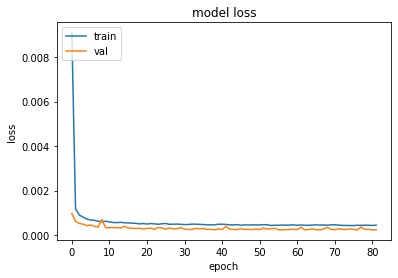

In [22]:
plt.plot(history.history['loss'], label='train')  # plotting train loss
plt.plot(history.history['val_loss'], label='val')  # plotting validation loss

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# shape input for model
test_X, test_y = to_supervised(test, n_input =24)
input_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))

# make forecast
yhat = model.predict(input_X)

# invert scaling for actual
inv_test_y = concatenate((test_y, input_X[:, -21:]), axis=1)
inv_test_y = scaler.inverse_transform(inv_test_y)
inv_test_y= inv_test_y[:, 0]

# invert scaling for predictions
inv_yhat = concatenate((yhat, input_X[:, -21:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# estimate prediction error
rmse = sqrt(mean_squared_error(inv_test_y,inv_yhat))
print('RMSE: %.3f' % (rmse))

mae = mean_absolute_error(inv_test_y, inv_yhat)
print('Test MAE: %.3f' % mae)

R2=r2_score(inv_test_y, inv_yhat)
print('Test R2: %.3f' % R2)

RMSE: 19.869
Test MAE: 11.745
Test R2: 0.965


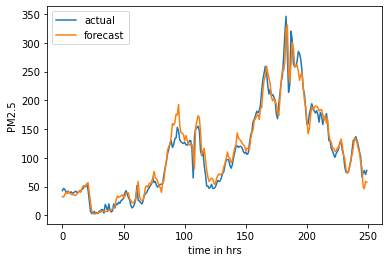

In [24]:
plt.plot(inv_test_y[ :250], label='actual')  # plotting actual
plt.plot(inv_yhat[ :250], label='forecast')  # plotting forecast

plt.ylabel('PM2.5')
plt.xlabel('time in hrs')
plt.legend(['actual', 'forecast'], loc='upper left')
plt.show()